In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np
from random import sample
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

import os
import matplotlib.image as mpimg
import cv2


In [14]:
batch_size= 32
TRAIN_PATH= 'gdrive/My Drive/Colab Notebooks/flower/train'
VAL_PATH= 'gdrive/My Drive/Colab Notebooks/flower/val'
TEST_PATH= 'gdrive/My Drive/Colab Notebooks/flower/test'

# Preprocessing
transform = transforms.Compose([transforms.Resize(256),transforms.RandomCrop(224),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

# Load images

trainset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=4)

valset = torchvision.datasets.ImageFolder(root=VAL_PATH, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True,num_workers=4)

testset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True,num_workers=4)

dataloader={'train':trainloader,'val':valloader,'test':testloader}
datasize={'train':len(trainset),'val':len(valset),'test':len(testset)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes=trainset.classes
print(classes)


['daisy', 'rose', 'sunflower', 'tulip']


In [0]:
def train_model(model, num_epochs=30):
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for images, labels in dataloader[phase]:
              
                images=images.to(device)
                labels=labels.to(device)
                images=images.view(images.shape[0],3,224,224)  
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    images=images.view(images.shape[0],3,224,224)
                    outputs = model(images)
                    preds = torch.argmax(outputs.reshape(outputs.shape[0],-1),dim=1)
                    loss = loss_fn(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasize[phase]
            epoch_acc = running_corrects.double() / datasize[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # record the best epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    print('Best val Acc: {:.4f} '.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [0]:
class Net(nn.Module):
    """
    Neural net
    """
   
    def __init__(self):
        """
        Constructor
        """
        super(Net, self).__init__()
        
        # Stride – the rate at which the kernel passes over the input image. 
        # A stride of 1 moves the kernel in 1-pixel increments.
        # Padding – we can add layers of 0s to the outside of the image in order 
        # to make sure that the kernel properly passes over the edges of the image.
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
    
        self.drop_out1 = nn.Dropout(0.2)
        self.drop_out2 = nn.Dropout(0.3)
        self.drop_out3 = nn.Dropout(0.4)
        
        
        self.fc1 = nn.Linear(25088, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 120)
        self.fc4 = nn.Linear(120, 4)
    
    def forward(self, x):
      
        x = self.layer1(x)
        x = self.layer2(x)
        x= self.drop_out1(x) 
        x = self.layer3(x)
        x = self.layer4(x)
    
        
        x = x.view(x.size(0),-1)
        
        x= self.drop_out2(x)
        
        x = F.relu(self.fc1(x))
        x= self.drop_out3(x)  
        x = F.relu(self.fc2(x))
        x= self.drop_out3(x) 
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [36]:
import torch.nn.functional as F

net = Net()
net = net.to(device)
model=train_model(net)

Epoch 1/40
----------
train Loss: 1.2718 Acc: 0.3838
val Loss: 1.3360 Acc: 0.2232

Epoch 2/40
----------
train Loss: 1.1115 Acc: 0.4778
val Loss: 1.1023 Acc: 0.5759

Epoch 3/40
----------
train Loss: 0.9940 Acc: 0.5752
val Loss: 1.0268 Acc: 0.6101

Epoch 4/40
----------
train Loss: 0.9076 Acc: 0.6149
val Loss: 1.0108 Acc: 0.5863

Epoch 5/40
----------
train Loss: 0.8410 Acc: 0.6611
val Loss: 0.8926 Acc: 0.6161

Epoch 6/40
----------
train Loss: 0.8185 Acc: 0.6555
val Loss: 0.9324 Acc: 0.6161

Epoch 7/40
----------
train Loss: 0.7888 Acc: 0.6697
val Loss: 0.9192 Acc: 0.6280

Epoch 8/40
----------
train Loss: 0.7841 Acc: 0.6839
val Loss: 0.8280 Acc: 0.6458

Epoch 9/40
----------
train Loss: 0.7382 Acc: 0.6994
val Loss: 0.8117 Acc: 0.6652

Epoch 10/40
----------
train Loss: 0.7125 Acc: 0.7046
val Loss: 0.8718 Acc: 0.6280

Epoch 11/40
----------
train Loss: 0.7078 Acc: 0.7167
val Loss: 0.8103 Acc: 0.6786

Epoch 12/40
----------
train Loss: 0.6960 Acc: 0.7188
val Loss: 0.8106 Acc: 0.6682

E

KeyboardInterrupt: ignored

In [0]:
#Save model
torch.save(model.state_dict(),"gdrive/My Drive/Colab Notebooks/trained_model.pth")

In [16]:
import torch.nn.functional as F
# Load model
model=Net()
model.load_state_dict(torch.load("gdrive/My Drive/Colab Notebooks/trained_model.pth")) 
model.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out1): Dropout(p=0.2)
  (drop_out2): Dropout(p=0.3)
  (drop_out3): Dropout(p=0.4)
  (fc1): Linear(in_features=25088, out_features=5000, bias=True)
  (fc2): Linear(in_features=

Test the model on testset and analyse the performance

Test accuracy: 0.7625


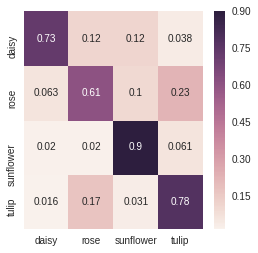

In [19]:
correction=0.0
pred=np.array([])
target=np.array([])
for images,labels in testloader:           
    images=images.view(images.shape[0],3,224,224)
    test_output = model(images)
    test_output = torch.argmax(test_output.reshape(test_output.shape[0], -1), dim=1)
    pred=np.concatenate((pred,test_output))
    target=np.concatenate((target,labels))
    correction += torch.sum(test_output == labels).item()
# Accuracy
test_acc=correction/len(testset)
print("Test accuracy:", test_acc)
# Confusion matrix
cm=confusion_matrix(target,pred)
cm=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm,classes,classes)
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)

In [38]:
# Precision, recall and f1 score
from sklearn.metrics import classification_report
print(classification_report(target, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.77      0.84        78
         1.0       0.73      0.66      0.69        79
         2.0       0.81      0.86      0.83        99
         3.0       0.63      0.78      0.70        64

   micro avg       0.77      0.77      0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.78      0.77      0.77       320



In [0]:
# Test the model on a single picture for showcase
from PIL import Image
PATH= 'gdrive/My Drive/Colab Notebooks/sample/daisy.jpeg'
transform = transforms.Compose([transforms.Resize(256),transforms.RandomCrop(224),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
imsize = 256

def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = transform(image).float()
    image = image.unsqueeze(0)
    return image

image = image_loader(PATH)
output=model(image)
prediction = torch.argmax(output)
print(classes[prediction.item()])